Diagnoses use ICD9 - can cluster them into the chapters: https://en.wikipedia.org/wiki/List_of_ICD-9_codes

We already have:
- number of medications
- We have discharge dest and if they were admitted as an emergency


Initial thoughts:

- From the data, those with more medical history - more hospital visits, etc., more medications, 
- discharged to home also was less on non-readdmissions - but discharged to home /w some health service etc. was higher - aligns with people with more medical needs not doing welll after they leave hospital
- also those with "change" in medication see higher rates of readmission
- those with diabetes meds see higher rates of readmission

The story is, those with complex health needs, (made easier to get meds wrong if they've changed), are more likely to see readmission

NEED TO LOOK AT CHARLSON
https://github.com/samisaf/Calculating-Charlson-comorbidity-index-based-on-ICD9-codes/blob/master/input/CharlsonRules3.csv


Methods:
- correlation matrix on the inputs
- pairgrid on the inputs
- think about ROC and AUC
    - what is the best threshold? Does this matter for this problem? (probably, as we want to predict if specific patients would be readmitted)
- R2 - what degree of variation in the data do the models explain?
- for the complex model - the SHAP / LIME for explanability
- error bars? Need to use stats models for logistic regression. Clean up the code.

more generally:
- the idea of medical device vs clinical information system.
- 

In [1]:
import pandas as pd
import seaborn as sns
import src.utils as utils

recalculate = False

In [2]:
if recalculate:
    file_path = "data/Diabetes.xlsx"

    # Load the Excel file into a pandas dataframe
    df = pd.read_excel(file_path)
    df['age_interval'] = df['age'].apply(utils.interval_type)
    df['age_factor'] = df['age_interval'].apply(utils.charlson_factor_age)
    df['diag_1_factor'] = df['diag_1'].apply(utils.charlson_factor_icd9)
    df['diag_2_factor'] = df['diag_2'].apply(utils.charlson_factor_icd9)
    df['diag_3_factor'] = df['diag_3'].apply(utils.charlson_factor_icd9)
    df['charlson_comorb_index'] = df.apply(lambda x: utils.charlson_comorb_index([x['diag_1'],x['diag_2'],x['diag_3']], x['age_interval']), axis=1)
    df.to_csv("data/Diabetes_Charlson.csv", index=False)
else:	
    df = pd.read_csv("data/Diabetes_Charlson.csv")

In [13]:
df['diag_1_category'] = df['diag_1'].apply(utils.categorise_icd9)
df['diag_2_category'] = df['diag_2'].apply(utils.categorise_icd9)
df['diag_3_category'] = df['diag_3'].apply(utils.categorise_icd9)

In [27]:
df.groupby(['diag_3_category'])['readmitted'].value_counts(normalize=True).unstack().sort_values(by=[True], ascending=True)

readmitted,False,True
diag_3_category,,
"complications of pregnancy, childbirth, and the puerperium",0.935484,0.064516
unknown,0.778846,0.221154
neoplasms,0.701987,0.298013
infectious and parasitic diseases,0.648241,0.351759
"endocrine, nutritional and metabolic diseases, and immunity disorders",0.632555,0.367445
diseases of the musculoskeletal system and connective tissue,0.610837,0.389163
external causes of injury and supplemental classification,0.598095,0.401905
"symptoms, signs, and ill-defined conditions",0.595023,0.404977
mental disorders,0.590747,0.409253


In [28]:
df.groupby(['diag_2_category'])['readmitted'].value_counts(normalize=True).unstack().sort_values(by=[True], ascending=True)

readmitted,False,True
diag_2_category,,
"complications of pregnancy, childbirth, and the puerperium",0.886364,0.113636
congenital anomalies,0.833333,0.166667
unknown,0.813559,0.186441
mental disorders,0.683333,0.316667
neoplasms,0.658436,0.341564
external causes of injury and supplemental classification,0.647773,0.352227
infectious and parasitic diseases,0.637363,0.362637
injury and poisoning,0.630435,0.369565
diseases of the blood and blood-forming organs,0.628159,0.371841


In [29]:
df.groupby(['diag_1_category'])['readmitted'].value_counts(normalize=True).unstack().sort_values(by=[True], ascending=True)

readmitted,False,True
diag_1_category,,
congenital anomalies,0.900000,0.100000
"complications of pregnancy, childbirth, and the puerperium",0.837838,0.162162
neoplasms,0.743590,0.256410
diseases of the blood and blood-forming organs,0.679012,0.320988
diseases of the musculoskeletal system and connective tissue,0.635317,0.364683
mental disorders,0.634783,0.365217
injury and poisoning,0.618750,0.381250
diseases of the digestive system,0.616927,0.383073
diseases of the genitourinary system,0.613995,0.386005


In [7]:
def discharged_home(discharge_disposition: str) -> str:
    """True if the patient was discharged to home, false otherwise"""
    return discharge_disposition == 'Discharged to home'

df['discharged_home'] = discharged_home(df['discharge_disposition_id'])

In [71]:
features = ['race', 'gender', 'age', 'weight', 'discharged_home', 
            'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
            'num_medications','number_outpatient', 'number_emergency', 'number_inpatient', 
            'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 
            'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 
            'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
            'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide.metformin',
            'glipizide.metformin', 'glimepiride.pioglitazone', 'metformin.rosiglitazone', 
            'metformin.pioglitazone', 'change', 'diabetesMed', 'charlson_comorb_index', 
            'diag_1_category']#, 'diag_2_category', 'diag_3_category']

target = df['readmitted']*1

numeric_features = df[features].select_dtypes(include='number').columns
categorical_features = list(set(df[features].columns) - set(numeric_features))

categorical_onehot = pd.get_dummies(df[categorical_features], drop_first=True)

df_onehot = pd.concat([df[numeric_features], categorical_onehot*1], axis=1)

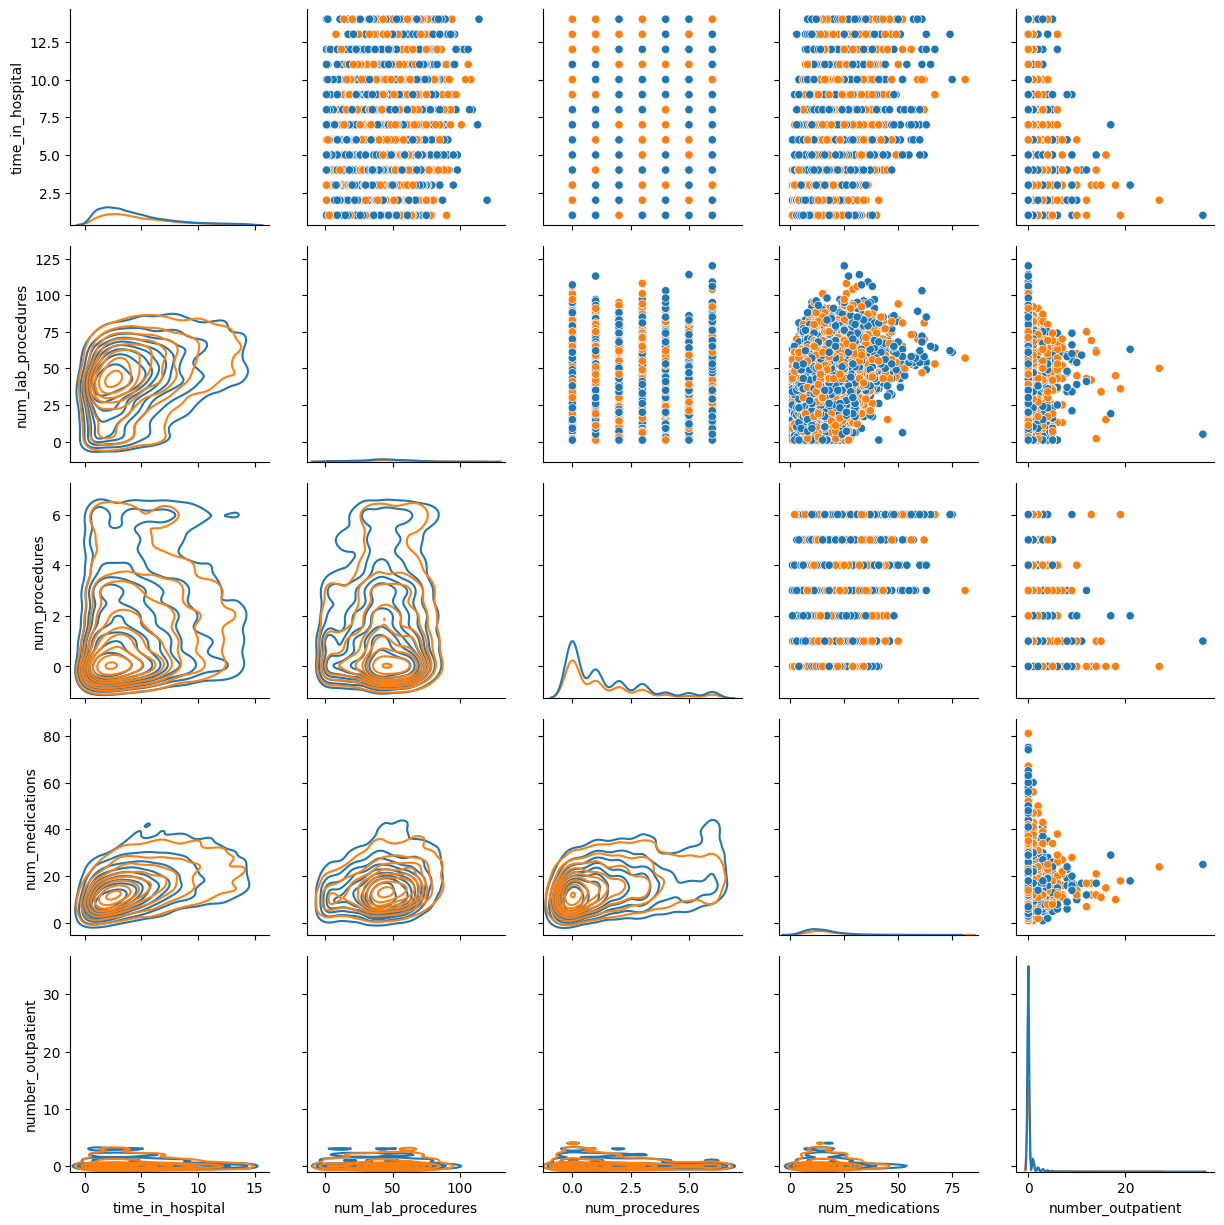

In [36]:
# g = sns.PairGrid(pd.concat([df_onehot[df_onehot.columns[:5]], target], axis=1), hue='readmitted')
# g.map_upper(sns.scatterplot)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)

In [72]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df_onehot) 
df_scaled = pd.DataFrame(scaled_values, columns=df_onehot.columns, index=df_onehot.index)

<Axes: >

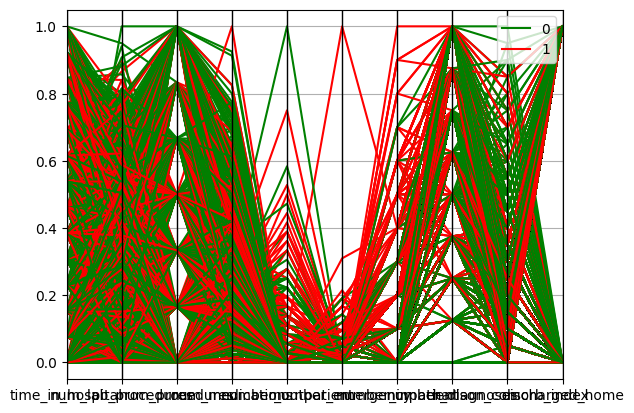

In [51]:
# pd.plotting.parallel_coordinates(pd.concat([df_scaled.iloc[:,0:10],target],axis=1), 'readmitted', color=('r', 'g'), sort_labels=True)

In [73]:
onehot_corr = pd.concat([df_scaled, target],axis=1).corr()#.sort_values('readmitted', ascending=False)

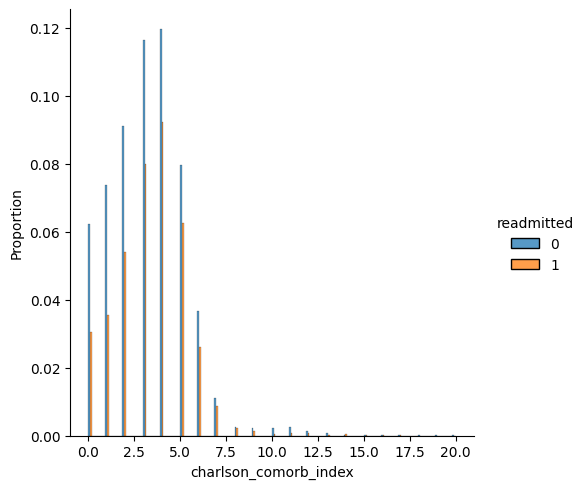

In [32]:
sns.displot(pd.concat([target, df_onehot['charlson_comorb_index']], axis=1),x = 'charlson_comorb_index', hue = 'readmitted', kde=False, stat='proportion', multiple='dodge')

In [74]:
for row in onehot_corr['readmitted'].sort_values().items():
    print(row)

('admission_source_id_Transfer from another health care facility', -0.05834369802428704)
('admission_source_id_Transfer from a hospital', -0.05766858845917596)
('diag_1_category_neoplasms', -0.05462085730773187)
('pioglitazone_No', -0.05352674863194018)
('change_No', -0.05105874012075656)
('race_AfricanAmerican', -0.048488689427935584)
('age_[30-40)', -0.04432154721055242)
('repaglinide_No', -0.02969664593980651)
('age_[40-50)', -0.029439420163238562)
('num_procedures', -0.027294684198400213)
('age_[10-20)', -0.02609812419161703)
('insulin_No', -0.02435700138562356)
('admission_source_id_Transfer from a Skilled Nursing Facility (SNF)', -0.024263204584706894)
('age_[50-60)', -0.02315955413277379)
('age_[90-100)', -0.02311637112318206)
('metformin_Up', -0.023040948522071076)
('admission_source_id_Physician Referral', -0.022490971170479643)
('admission_source_id_Not Available', -0.02221863149353919)
('age_[20-30)', -0.02186683824466905)
('A1Cresult_Norm', -0.019400733431515788)
('diag_1_c

In [75]:

for column in onehot_corr.columns:
    print(column, ": ", onehot_corr[column].drop(column).sort_values(ascending=False).head(5))
    print("")

time_in_hospital :  num_medications                                                              0.475244
num_lab_procedures                                                           0.291957
number_diagnoses                                                             0.258570
num_procedures                                                               0.201540
diag_1_category_external causes of injury and supplemental classification    0.134127
Name: time_in_hospital, dtype: float64

num_lab_procedures :  time_in_hospital                      0.291957
admission_source_id_Emergency Room    0.246371
num_medications                       0.236220
A1Cresult_>8                          0.185432
number_diagnoses                      0.151874
Name: num_lab_procedures, dtype: float64

num_procedures :  num_medications                                       0.424500
diag_1_category_diseases of the circulatory system    0.254809
time_in_hospital                                      0.201540
admi

In [76]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)
result = calc_vif(onehot_corr)

In [77]:
result[result['VIF']>10].sort_values('VIF', ascending=False)

,variables,VIF
85,age_[70-80),28166.924324
34,rosiglitazone_No,26487.887553
35,rosiglitazone_Steady,25303.316604
84,age_[60-70),22526.615044
86,age_[80-90),20306.242486
...,...,...
43,miglitol_Up,14.894252
65,race_Other,14.457164
3,num_medications,10.455141
39,insulin_Up,10.243546


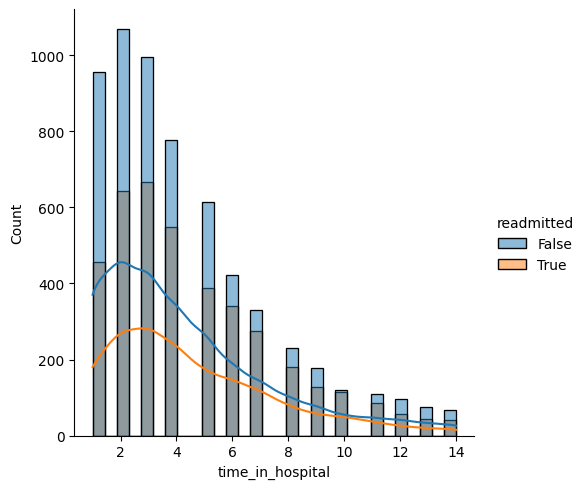

In [78]:
# make histogram of age variable split by readmitted
sns.displot(df, x='time_in_hospital', bins=30, kde=True,hue='readmitted')

In [ ]:
#sns.heatmap(df[df.columns[df.dtypes != 'object']], annot=True, fmt=".2f", cmap="coolwarm")

           time_in_hospital                                              
                      count      mean       std  min  25%  50%  75%   max
readmitted                                                               
False                6035.0  4.308534  3.027208  1.0  2.0  4.0  6.0  14.0
True                 3965.0  4.626734  3.003260  1.0  2.0  4.0  6.0  14.0
           num_lab_procedures                                               \
                        count       mean        std  min   25%   50%   75%   
readmitted                                                                   
False                  6035.0  41.791218  19.244476  1.0  30.0  43.0  55.0   
True                   3965.0  45.038083  19.607779  1.0  34.0  46.0  60.0   

                   
              max  
readmitted         
False       120.0  
True        108.0  
           num_procedures                                             
                    count      mean       std  min  25%  50%  75%  m

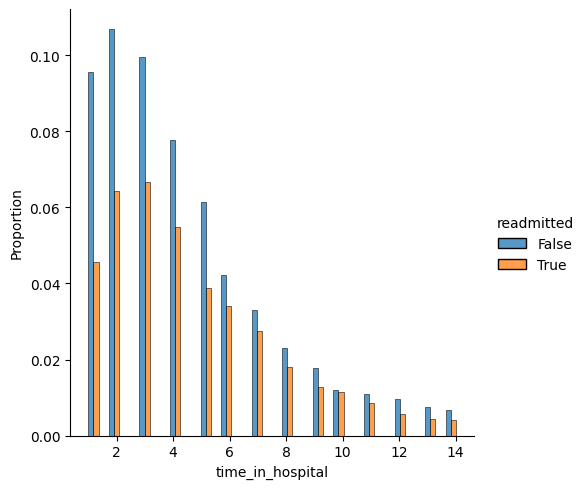

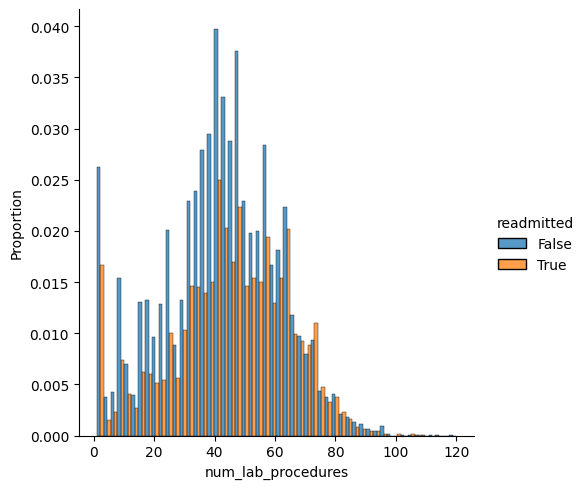

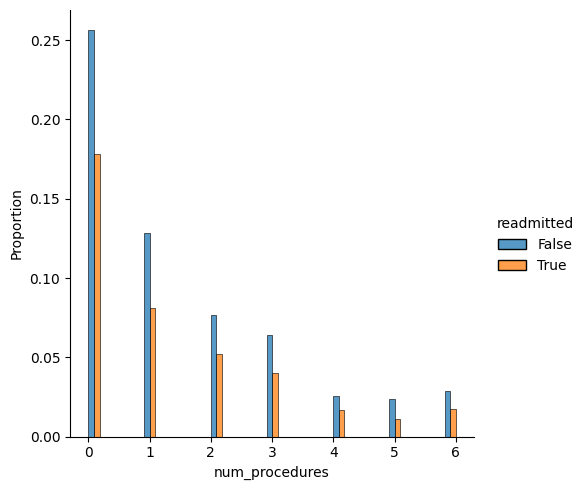

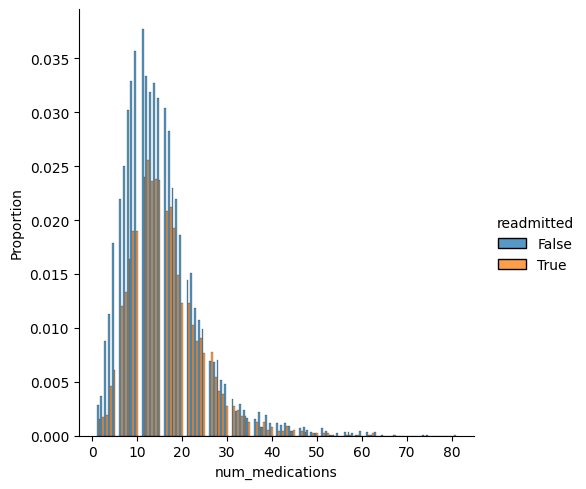

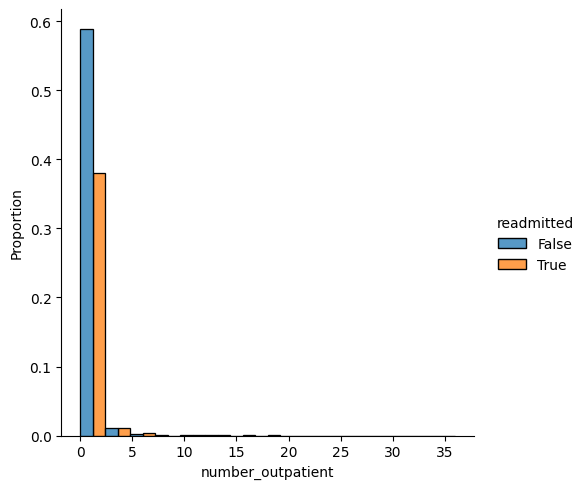

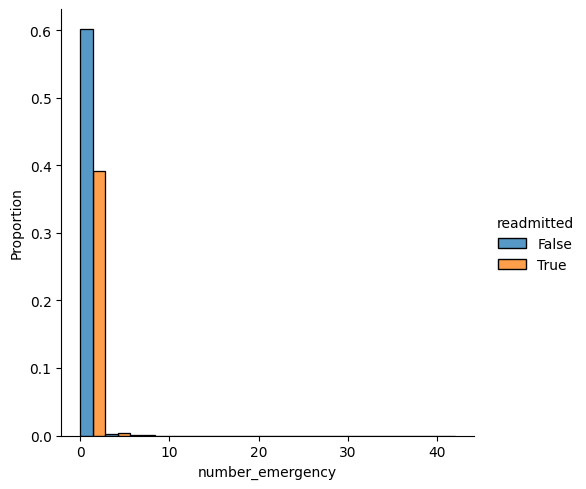

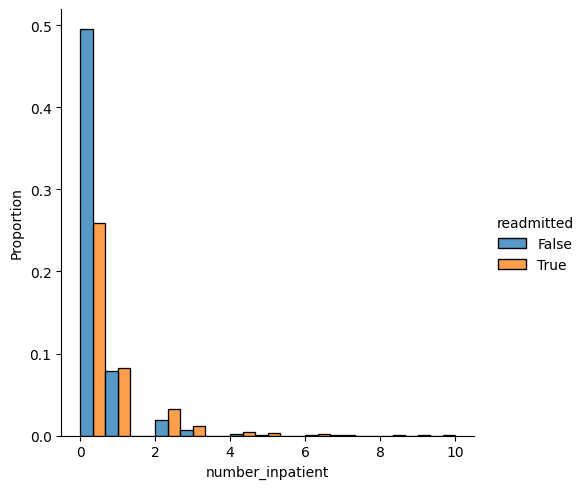

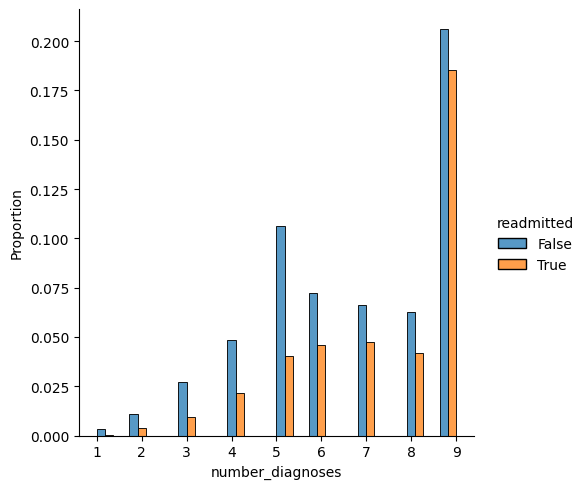

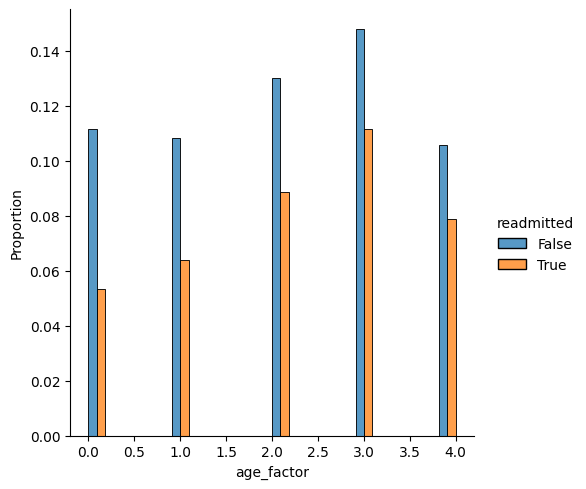

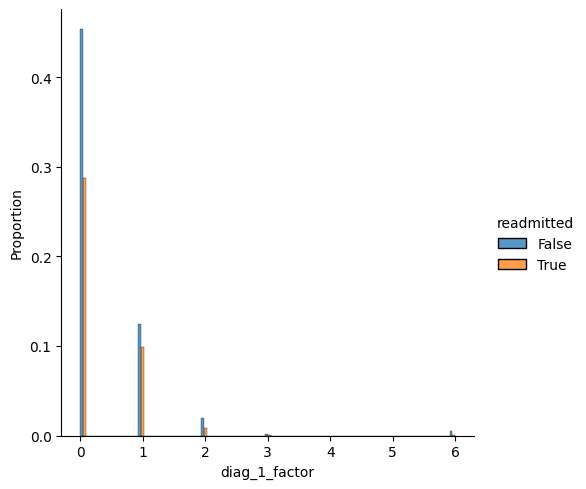

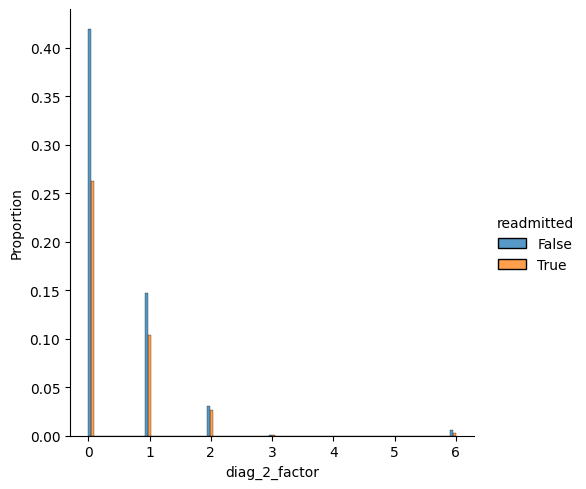

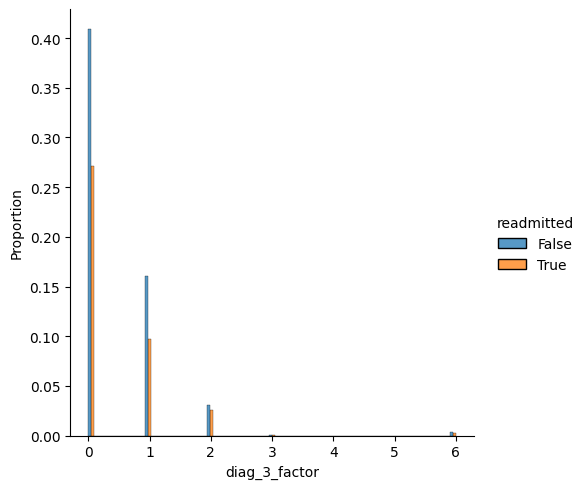

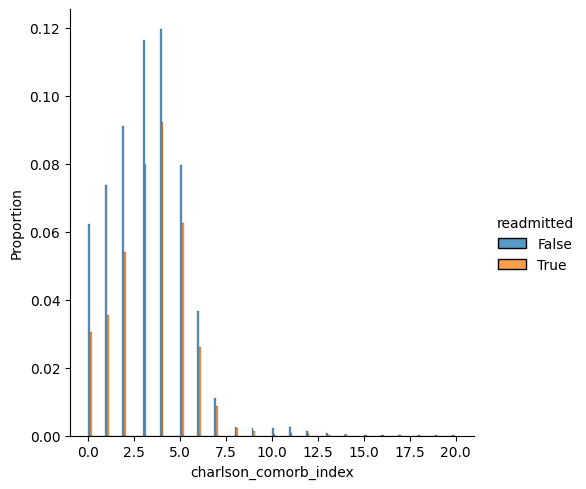

In [79]:
for int64_column in df.columns[df.dtypes == 'int64']:
    #print(int64_column)
    sns.displot(df, x=int64_column,hue='readmitted', stat='proportion', multiple='dodge')
    group_readmitted = df.loc[:,[int64_column,'readmitted']].groupby('readmitted')
    print(group_readmitted.describe())


In [80]:
def group_and_value_count_by_readmitted(df,column):
    """Returns a dataframe with the count of each value in the specified column grouped by readmitted"""
    
    group_readmitted = df.loc[:,[column,'readmitted']].groupby('readmitted')

    return pd.concat([group_readmitted.value_counts(normalize=True),
               group_readmitted.value_counts()
               ],axis=1)

for cat_column in df.drop('readmitted',axis=1).columns:#[df.dtypes == 'object']:
    print(cat_column)
    print(group_and_value_count_by_readmitted(df,cat_column).unstack(0))

    

race
                proportion           count      
readmitted           False     True  False True 
race                                            
?                 0.027672  0.013619   167    54
AfricanAmerican   0.222204  0.182093  1341   722
Asian             0.005965  0.004792    36    19
Caucasian         0.711682  0.772762  4295  3064
Hispanic          0.019221  0.016393   116    65
Other             0.013256  0.010340    80    41
gender
           proportion           count      
readmitted      False     True  False True 
gender                                     
Female       0.534714  0.547541  3227  2171
Male         0.465286  0.452459  2808  1794
age
           proportion           count      
readmitted      False     True  False True 
age                                        
[0-10)       0.004640  0.000757    28     3
[10-20)      0.010108  0.005296    61    21
[20-30)      0.016404  0.011097    99    44
[30-40)      0.048882  0.030769   295   122
[40-50)      0.

# thoughts
- So - this ISNT an imbalanced dataset - so don't need to worry about that

In [104]:
import sklearn

# use a tree model to predict readmission
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

# import random forest classifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

from sklearn.model_selection import train_test_split


# one-hot encode the categorical variables
#f_onehot = pd.get_dummies(df.drop('readmitted',axis=1), drop_first=True)

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_onehot, 
                                                    target, test_size=0.30, 
                                                    random_state=101, stratify=df['readmitted'])

# create a decision tree classifier instance


scaler = StandardScaler()
#model = LogisticRegression(penalty='l2', max_iter=10000, C=0.1, n_jobs=-1)#
#model = GradientBoostingClassifier(n_estimators=100, max_depth=4)
model = xgb.XGBClassifier()#n_estimators=1000, subsample=0.8, colsample_bytree=0.8, max_depth=5)

pipe = Pipeline([('scaler', scaler), ('model', model)]) 

# fit the decision tree classifier
pipe.fit(X_train,y_train)

train_predictions_proba = pipe.predict_proba(X_train)[:,1]

# use the classifier to predict
predictions_proba = pipe.predict_proba(X_test)[:,1] # select only positive class

optimun_threshold = 0.5
predictions  = (predictions_proba > optimun_threshold)*1
train_predictions  = (train_predictions_proba > optimun_threshold)*1


# import the metrics class
from sklearn import metrics
from sklearn.metrics import r2_score


tpr, fpr, thresholds = metrics.roc_curve(y_train,train_predictions_proba)
roc_auc = auc(tpr, fpr)
test_tpr, test_fpr, thresholds = metrics.roc_curve(y_test,predictions_proba)
test_roc_auc = auc(test_tpr, test_fpr)

r2_score_value = r2_score(y_test, predictions_proba)
print("R2 Score:", r2_score_value)
r2_score_value = r2_score(y_train, train_predictions_proba)
print("Train R2 Score:", r2_score_value)


# show the confusion matrix

print("train roc_auc: ", roc_auc)
print("test roc_auc: ", test_roc_auc)
print(metrics.confusion_matrix(y_test,predictions))
print(metrics.classification_report(y_train,train_predictions))

# show the accuracy, precision, and recall
print(metrics.classification_report(y_test,predictions))

R2 Score: 0.027172414612273155
Train R2 Score: 0.5311021532137012
train roc_auc:  0.9512951010181779
test roc_auc:  0.6451190863085565
[[1420  390]
 [ 720  470]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4225
           1       0.91      0.76      0.83      2775

    accuracy                           0.87      7000
   macro avg       0.88      0.85      0.86      7000
weighted avg       0.88      0.87      0.87      7000

              precision    recall  f1-score   support

           0       0.66      0.78      0.72      1810
           1       0.55      0.39      0.46      1190

    accuracy                           0.63      3000
   macro avg       0.61      0.59      0.59      3000
weighted avg       0.62      0.63      0.62      3000



In [64]:
# calculate f1 score for each threshold value
# f1 = 2 * (precision * recall) / (precision + recall)
# then you can get the argmax of the f1 score and use this to get the best theshold.

inf

In [62]:
thresholds[fpr.argmax()]

0.0801166327866325

In [46]:
df_train_outputs = pd.concat([pd.Series(y_train, name='y_train'),pd.Series(train_predictions, name="train_predictions")],axis=1)

df_train_outputs.query("y_train == train_predictions")

,y_train,train_predictions
3165,0.0,0.0
1659,0.0,0.0
1237,0.0,0.0
347,0.0,0.0
4967,0.0,0.0
...,...,...
3369,0.0,0.0
4548,1.0,1.0
4825,1.0,1.0
6302,0.0,0.0


In [90]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
# param_grid = {'model__solver': ['liblinear', 'saga'], # 'newton-cg', 'lbfgs', 'sag', 'saga
#     'model__penalty': ['l1', 'l2'],
#     'model__C': [0.1, 1, 10]
# }

param_grid = {'model__eta': [0.01, 0.1, 0.2], # 'newton-cg', 'lbfgs', 'sag', 'saga
    'model__max_depth': [3,5,10],
    'model__subsample': [0.5,0.8,1],
    'model__colsample_bytree': [0.5,0.8,1],
}

# Create the grid search object
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1_micro') #'roc_auc',)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'model__colsample_bytree': 1, 'model__eta': 0.1, 'model__max_depth': 3, 'model__subsample': 1}
Best Score: 0.6442857142857142


In [94]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__eta,param_model__max_depth,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.712942,0.037448,0.023722,0.003948,0.5,0.01,3,0.5,"{'model__colsample_bytree': 0.5, 'model__eta':...",0.620000,0.627857,0.616429,0.624286,0.622143,0.622143,0.003860,69
1,0.754479,0.091668,0.030826,0.013116,0.5,0.01,3,0.8,"{'model__colsample_bytree': 0.5, 'model__eta':...",0.622857,0.627143,0.613571,0.616429,0.622143,0.620429,0.004836,70
2,0.681763,0.080571,0.025712,0.004415,0.5,0.01,3,1,"{'model__colsample_bytree': 0.5, 'model__eta':...",0.620000,0.629286,0.615000,0.617143,0.620000,0.620286,0.004878,71
3,0.895436,0.137925,0.023023,0.003299,0.5,0.01,5,0.5,"{'model__colsample_bytree': 0.5, 'model__eta':...",0.622857,0.628571,0.617857,0.627143,0.621429,0.623571,0.003886,65
4,0.932730,0.117520,0.032722,0.011381,0.5,0.01,5,0.8,"{'model__colsample_bytree': 0.5, 'model__eta':...",0.631429,0.631429,0.620000,0.625714,0.626429,0.627000,0.004247,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.840053,0.085901,0.037915,0.014864,1,0.2,5,0.8,"{'model__colsample_bytree': 1, 'model__eta': 0...",0.612143,0.617143,0.631429,0.632143,0.630000,0.624571,0.008288,64
77,0.742105,0.049738,0.030429,0.005753,1,0.2,5,1,"{'model__colsample_bytree': 1, 'model__eta': 0...",0.617143,0.644286,0.618571,0.634286,0.636429,0.630143,0.010579,44
78,1.595080,0.122513,0.038917,0.007963,1,0.2,10,0.5,"{'model__colsample_bytree': 1, 'model__eta': 0...",0.612143,0.618571,0.598571,0.599286,0.611429,0.608000,0.007817,81
79,1.637473,0.194343,0.041724,0.012759,1,0.2,10,0.8,"{'model__colsample_bytree': 1, 'model__eta': 0...",0.609286,0.623571,0.607857,0.613571,0.595000,0.609857,0.009241,77


In [58]:
train_predictions_proba = grid_search.predict_proba(X_train)[:,1]

# use the classifier to predict
predictions_proba = grid_search.predict_proba(X_test)[:,1] # select only positive class

optimun_threshold = 0.5
predictions  = (predictions_proba > optimun_threshold)*1
train_predictions  = (train_predictions_proba > optimun_threshold)*1


# import the metrics class
from sklearn import metrics
from sklearn.metrics import r2_score


tpr, fpr, thresholds = metrics.roc_curve(y_train,train_predictions_proba)
roc_auc = auc(tpr, fpr)
test_tpr, test_fpr, thresholds = metrics.roc_curve(y_test,predictions_proba)
test_roc_auc = auc(test_tpr, test_fpr)

r2_score_value = r2_score(y_test, predictions_proba)
print("R2 Score:", r2_score_value)
r2_score_value = r2_score(y_train, train_predictions_proba)
print("Train R2 Score:", r2_score_value)


# show the confusion matrix

print("train roc_auc: ", roc_auc)
print("test roc_auc: ", test_roc_auc)
print(metrics.confusion_matrix(y_test,predictions))
print(metrics.classification_report(y_train,train_predictions))

# show the accuracy, precision, and recall
print(metrics.classification_report(y_test,predictions))

R2 Score: 0.08933315258218211
Train R2 Score: 0.15485997944789076
train roc_auc:  0.7360027293565755
test roc_auc:  0.6719601652815823
[[1574  236]
 [ 782  408]]
              precision    recall  f1-score   support

           0       0.68      0.89      0.77      4225
           1       0.68      0.37      0.48      2775

    accuracy                           0.68      7000
   macro avg       0.68      0.63      0.63      7000
weighted avg       0.68      0.68      0.66      7000

              precision    recall  f1-score   support

           0       0.67      0.87      0.76      1810
           1       0.63      0.34      0.44      1190

    accuracy                           0.66      3000
   macro avg       0.65      0.61      0.60      3000
weighted avg       0.65      0.66      0.63      3000



In [60]:
import statsmodels.api as sm

y = target
x = sm.add_constant(df_onehot)

sm_model = sm.Logit(y, x).fit()

print(sm_model.summary())

         Current function value: 0.616081
         Iterations: 35


d:\PycharmProjects\readmission\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:             readmitted   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9856
Method:                           MLE   Df Model:                          143
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                 0.08262
Time:                        07:50:17   Log-Likelihood:                -6160.8
converged:                      False   LL-Null:                       -6715.7
Covariance Type:            nonrobust   LLR p-value:                3.522e-149
                                                                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                       